In [2]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

print('Imports Complete')

Imports Complete


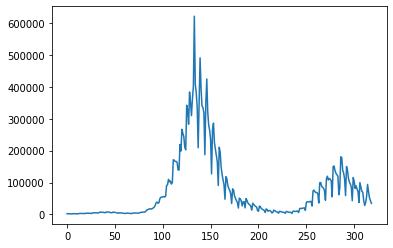

In [3]:
from pandas import read_csv

dataframe = read_csv('covid_19_res.csv', usecols=[12], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

plt.plot(dataset)

In [4]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [5]:
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 20

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [7]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [11]:
model2 = Sequential()
model2.add(InputLayer((look_back,1)))
model2.add(Conv1D(64, kernel_size=2)) 
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 19, 64)            192       
                                                                 
 flatten_1 (Flatten)         (None, 1216)              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 9736      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,937
Trainable params: 9,937
Non-trainable params: 0
_________________________________________________________________


In [12]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [13]:
model2.fit(trainX, trainY, epochs=10, verbose=1, callbacks=[cp2])

Epoch 1/10
6/6 [==============================] - 4s 4ms/step - loss: 0.0254 - root_mean_squared_error: 0.1594
Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0115 - root_mean_squared_error: 0.1075
Epoch 3/10
6/6 [==============================] - 0s 5ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0061 - root_mean_squared_error: 0.0783
Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - root_mean_squared_error: 0.0698
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0045 - root_mean_squared_error: 0.0669
Epoch 8/10
6/6 [==============================] - 0s 5ms/step - loss: 0.0044 - root_mean_squared_error: 0.0664
Epoch 9/10
6/6 [==============================] - 0s 4ms/step - loss: 0.0043 - root_mean_squared_error: 0.0658
E

In [14]:
# make predictions
trainPredict = model2.predict(trainX)
testPredict = model2.predict(testX)

In [16]:
from sklearn.metrics import mean_squared_error

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 39050.30 RMSE
Test Score: 22786.78 RMSE


In [19]:
train = pd.read_csv('covid_19_res.csv', encoding='utf-8')
train.head()
train.index = pd.to_datetime(train['서울시 기준일'], format='%Y.%m.%d.%h',errors='ignore')
time = train.index

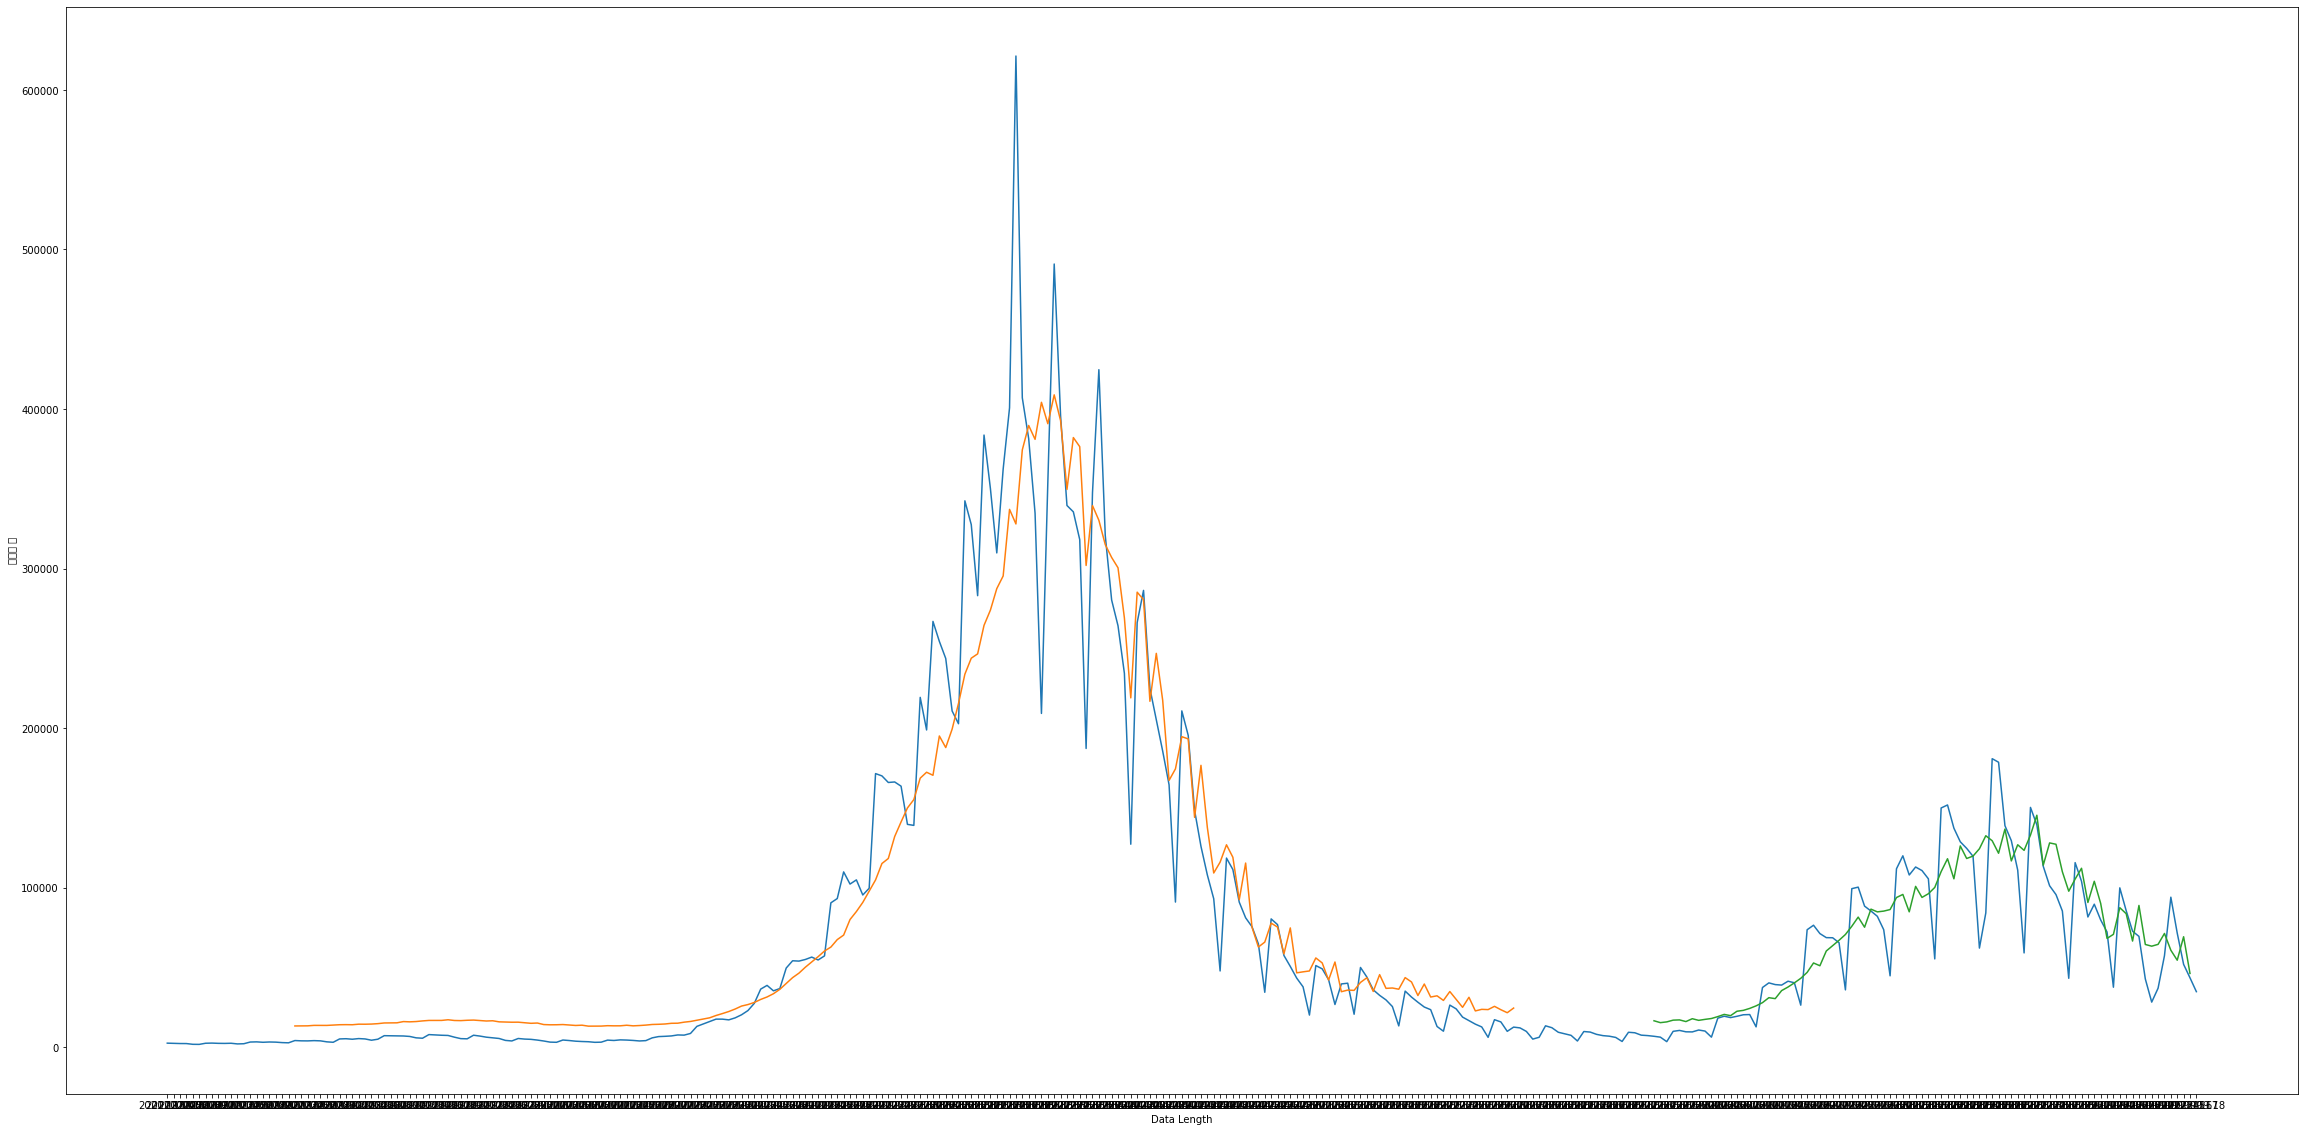

In [20]:

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


korea_TrainPredict = trainPredictPlot
korea_TestPredict = testPredictPlot
# plot baseline and predictions
plt.figure(figsize=(40,20))
plt.plot(time,scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)


plt.xlabel("Data Length")
plt.ylabel("확진자 수")


plt.show()